In [ ]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 452.9/452.9 KB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 26.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 24.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 12.3 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [ ]:
import os
import pickle

import numpy as np 
import tensorflow as tf
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt

from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, Embedding, GlobalMaxPooling1D, Conv1D, MaxPooling1D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Model
from tensorflow.keras.utils import plot_model
from IPython.display import Image 

from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import MultiLabelBinarizer 

from datasets import load_dataset

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Load fasttext embeddings

In [ ]:
"""
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz
!gzip -d cc.en.300.vec.gz
"""

'\n!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz\n!gzip -d cc.en.300.vec.gz\n'

In [ ]:
"""
idx = 0
# dictionary from word to index of 2d array
vocab = {}
with open("cc.en.300.vec", 'r', encoding="utf-8", newline='\n',errors='ignore') as f:
    for l in f:
        line = l.rstrip().split(' ')
        if idx == 0:
            vocab_size = int(line[0]) + 2
            dim = int(line[1])
            #vector words x embedding_size
            vecs = np.zeros(vocab_size*dim).reshape(vocab_size,dim)
            vocab["__PADDING__"] = 0
            vocab["__UNK__"] = 1
            idx = 2
        else:
            vocab[line[0]] = idx
            emb = np.array(line[1:]).astype(np.float)
            if (emb.shape[0] == dim):
                vecs[idx,:] = emb
                idx+=1
            else:
                continue

    pickle.dump(vocab,open("/content/gdrive/My Drive/fasttext_voc.pkl" ,'wb'))
    np.save("/content/gdrive/My Drive/fasttext.npy",vecs)
    # Free ram
    vecs = None
    vocab = None
    emb = None
"""

'\nidx = 0\n# dictionary from word to index of 2d array\nvocab = {}\nwith open("cc.en.300.vec", \'r\', encoding="utf-8", newline=\'\n\',errors=\'ignore\') as f:\n    for l in f:\n        line = l.rstrip().split(\' \')\n        if idx == 0:\n            vocab_size = int(line[0]) + 2\n            dim = int(line[1])\n            #vector words x embedding_size\n            vecs = np.zeros(vocab_size*dim).reshape(vocab_size,dim)\n            vocab["__PADDING__"] = 0\n            vocab["__UNK__"] = 1\n            idx = 2\n        else:\n            vocab[line[0]] = idx\n            emb = np.array(line[1:]).astype(np.float)\n            if (emb.shape[0] == dim):\n                vecs[idx,:] = emb\n                idx+=1\n            else:\n                continue\n\n    pickle.dump(vocab,open("/content/gdrive/My Drive/fasttext_voc.pkl" ,\'wb\'))\n    np.save("/content/gdrive/My Drive/fasttext.npy",vecs)\n    # Free ram\n    vecs = None\n    vocab = None\n    emb = None\n'

In [ ]:
fasttext_embed = np.load("/content/gdrive/My Drive/fasttext.npy")
fasttext_word_to_index = pickle.load(open("/content/gdrive/My Drive/fasttext_voc.pkl", 'rb')) 

## Evaluation metrics used from the CNN classifier

In [ ]:
"""
  Recall metric.
  Only computes a batch-wise average of recall.
  Computes the recall, a metric for multi-label classification of
  how many relevant items are selected.
"""

def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

In [ ]:
"""
  Precision metric.
  Only computes a batch-wise average of precision.
  Computes the precision, a metric for multi-label classification of
  how many selected items are relevant.
  Source
  ------
  https://github.com/fchollet/keras/issues/5400#issuecomment-314747992
"""

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

In [ ]:
"""
  Calculates the F1 score.
"""

def f1(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2 * ((p * r) / (p + r))

In [ ]:
"""
  Calculates the accuracy.
"""

def accuracy(y_true, y_pred):
    return K.mean(K.equal(y_true, K.round(y_pred)), axis=1)

## Load and preprocess dataset

In [ ]:
"""
    Loads the dataset.
"""

def load_ag_news_dataset():
    dataset = load_dataset("ag_news")
    
    train_x = []
    train_y = []
    dev_x = []
    dev_y = []
    test_x = []
    test_y = []

    for x in range(0, 6000):
        train_x.append(dataset['train'][x]['text'])
        train_y.append(dataset['train'][x]['label'])

    for x in range(6000, 7500):
        dev_x.append(dataset['train'][x]['text'])
        dev_y.append(dataset['train'][x]['label'])

    for x in range(0, 2000):
        test_x.append(dataset['test'][x]['text'])
        test_y.append(dataset['test'][x]['label'])
    
    return train_x, train_y, dev_x, dev_y, test_x, test_y

In [ ]:
# Load the dataset
train_x, train_y_, dev_x, dev_y_, test_x, test_y_ = load_ag_news_dataset()

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

Dataset ag_news downloaded and prepared to /root/.cache/huggingface/datasets/ag_news/default/0.0.0/bc2bcb40336ace1a0374767fc29bb0296cdaf8a6da7298436239c54d79180548. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
# Transform the outputs so they match the desired format
"""
mlb = MultiLabelBinarizer()

train_y = mlb.fit_transform([[y] for y in train_y])
dev_y = mlb.fit_transform([[y] for y in dev_y])
test_y = mlb.fit_transform([[y] for y in test_y])
"""

'\nmlb = MultiLabelBinarizer()\n\ntrain_y = mlb.fit_transform([[y] for y in train_y])\ndev_y = mlb.fit_transform([[y] for y in dev_y])\ntest_y = mlb.fit_transform([[y] for y in test_y])\n'

In [ ]:
from sklearn.preprocessing import label_binarize

#y_train_1_hot = label_binarize(train_y, classes=np.arange(4))
#y_val_1_hot = label_binarize(dev_y, classes=np.arange(4))
#y_test_1_hot = label_binarize(test_y, classes=np.arange(4))
"""
train_y_single = train_y
dev_y_single = dev_y
test_y_single = test_y
"""

train_y = label_binarize(train_y_, classes=np.arange(4))
dev_y = label_binarize(dev_y_, classes=np.arange(4))
test_y = label_binarize(test_y_, classes=np.arange(4))

print('y_train_1_hot[0]: {}'.format(train_y[0]))
print('y_val_1_hot[0]: {}'.format(dev_y[0]))
print('y_test_1_hot[0]: {}'.format(test_y[0]))

y_train_1_hot[0]: [0 0 1 0]
y_val_1_hot[0]: [0 1 0 0]
y_test_1_hot[0]: [0 0 1 0]


## Tokenize, convert text (sequence of words) to sequence of indices and PAD the sequences

In [ ]:
# Define needed constants 
MAX_WORDS = 10000
MAX_SEQUENCE_LENGTH = 200
EMBEDDING_DIM = 300

In [ ]:
# Configure the tokenizer 
tokenizer = Tokenizer(num_words=MAX_WORDS,oov_token='__UNK__')
tokenizer.fit_on_texts(train_x)

In [ ]:
train_seqs = tokenizer.texts_to_sequences(train_x)
dev_seqs = tokenizer.texts_to_sequences(dev_x)

train_data = pad_sequences(train_seqs, maxlen=MAX_SEQUENCE_LENGTH,padding='post')
dev_data = pad_sequences(dev_seqs, maxlen=MAX_SEQUENCE_LENGTH,padding='post')

In [ ]:
# Word index
word_index = tokenizer.word_index

In [ ]:
#fasttext_word_to_index['is']
#fasttext_embed[15]

In [ ]:
# Define model's embedding matrix
embedding_matrix = np.zeros((MAX_WORDS, EMBEDDING_DIM))

for word, i in word_index.items():
    if i > MAX_WORDS:
            continue
    try:
        embedding_vector = fasttext_embed[fasttext_word_to_index[word],:]
        embedding_matrix[i] = embedding_vector
    except:
        pass



In [ ]:
#embedding_matrix[871]

## Stacked CNNs followed by Max-Pooling

In [ ]:
# Set global environment variable
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [ ]:
# Global statements for CNN classifier
FILTERS = 128  # the dimensionality of the output space (i.e. the number of output filters in the convolution)
KERNEL = 3  # the length of the 1D convolution window
DENSE = 64
N_CLASSES = 4

target_list = ["World", "Sports", "Business", "Sci/Tech"]

with tf.device('/device:GPU:0'):

  # create empty sequential model
  model = Sequential()
  # add an embedding layer
  model.add(Embedding(input_dim=MAX_WORDS, # Size of the vocabulary, i.e. maximum integer index + 1
                      output_dim=EMBEDDING_DIM, 
                      weights=[embedding_matrix], 
                      input_length=MAX_SEQUENCE_LENGTH, trainable=False))
  # add 0.2 dropout probabillity
  model.add(Dropout(0.2))
  # add a stack of convolution layers
  model.add(Conv1D(filters=FILTERS, kernel_size=KERNEL, activation='relu', padding='valid'))
  model.add(Conv1D(filters=FILTERS, kernel_size=KERNEL, activation='relu', padding='valid'))
  model.add(Conv1D(filters=FILTERS, kernel_size=KERNEL, activation='relu', padding='valid'))
  model.add(Conv1D(filters=FILTERS, kernel_size=KERNEL, activation='relu', padding='valid'))
  model.add(Conv1D(filters=FILTERS, kernel_size=KERNEL, activation='relu', padding='valid'))
  # max pooling
  model.add(GlobalMaxPooling1D())
  # add 0.2 dropout probabillity
  model.add(Dropout(0.2))
  # add dense layer
  model.add(Dense(DENSE, activation='relu'))
  # add final linear layer
  model.add(Dense(N_CLASSES, activation='sigmoid'))

  print(model.summary())
  model.compile(loss='binary_crossentropy',
                optimizer=Adam(lr=0.001),
                metrics=[precision, recall, f1, accuracy])

  checkpoint = ModelCheckpoint('/content/gdrive/My Drive/keras_CNN_model', monitor='val_f1', verbose=1, save_best_only=True, mode='max')

  checkpoint2 = ModelCheckpoint('/content/gdrive/My Drive/checkpoints/stackedCNN.hdf5',
                               monitor='val_accuracy', 
                               mode='max', verbose=2,
                               save_best_only=True,
                               save_weights_only=True)

  history = model.fit(train_data, train_y,
                batch_size=32,
                epochs=50,
                verbose = 0,
                callbacks=[checkpoint, checkpoint2],
                validation_data=(dev_data, dev_y),
                shuffle=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 300)          3000000   
                                                                 
 dropout (Dropout)           (None, 200, 300)          0         
                                                                 
 conv1d (Conv1D)             (None, 198, 128)          115328    
                                                                 
 conv1d_1 (Conv1D)           (None, 196, 128)          49280     
                                                                 
 conv1d_2 (Conv1D)           (None, 194, 128)          49280     
                                                                 
 conv1d_3 (Conv1D)           (None, 192, 128)          49280     
                                                                 
 conv1d_4 (Conv1D)           (None, 190, 128)          4

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)



Epoch 1: val_f1 improved from -inf to 0.80392, saving model to /content/gdrive/My Drive/keras_CNN_model



Epoch 1: val_accuracy improved from -inf to 0.90583, saving model to /content/gdrive/My Drive/checkpoints/stackedCNN.hdf5

Epoch 2: val_f1 improved from 0.80392 to 0.83306, saving model to /content/gdrive/My Drive/keras_CNN_model



Epoch 2: val_accuracy improved from 0.90583 to 0.91867, saving model to /content/gdrive/My Drive/checkpoints/stackedCNN.hdf5

Epoch 3: val_f1 did not improve from 0.83306

Epoch 3: val_accuracy did not improve from 0.91867

Epoch 4: val_f1 improved from 0.83306 to 0.84247, saving model to /content/gdrive/My Drive/keras_CNN_model



Epoch 4: val_accuracy improved from 0.91867 to 0.92317, saving model to /content/gdrive/My Drive/checkpoints/stackedCNN.hdf5

Epoch 5: val_f1 improved from 0.84247 to 0.85002, saving model to /content/gdrive/My Drive/keras_CNN_model



Epoch 5: val_accuracy improved from 0.92317 to 0.92667, saving model to /content/gdrive/My Drive/checkpoints/stackedCNN.hdf5

Epoch 6: val_f1 did not improve from 0.85002

Epoch 6: val_accuracy did not improve from 0.92667

Epoch 7: val_f1 did not improve from 0.85002

Epoch 7: val_accuracy did not improve from 0.92667

Epoch 8: val_f1 did not improve from 0.85002

Epoch 8: val_accuracy did not improve from 0.92667

Epoch 9: val_f1 did not improve from 0.85002

Epoch 9: val_accuracy did not improve from 0.92667

Epoch 10: val_f1 did not improve from 0.85002

Epoch 10: val_accuracy did not improve from 0.92667

Epoch 11: val_f1 did not improve from 0.85002

Epoch 11: val_accuracy did not improve from 0.92667

Epoch 12: val_f1 did not improve from 0.85002

Epoch 12: val_accuracy did not improve from 0.92667

Epoch 13: val_f1 did not improve from 0.85002

Epoch 13: val_accuracy did not improve from 0.92667

Epoch 14: val_f1 did not improve from 0.85002

Epoch 14: val_accuracy did not imp


Epoch 17: val_accuracy did not improve from 0.92667

Epoch 18: val_f1 did not improve from 0.85086

Epoch 18: val_accuracy did not improve from 0.92667

Epoch 19: val_f1 did not improve from 0.85086

Epoch 19: val_accuracy did not improve from 0.92667

Epoch 20: val_f1 did not improve from 0.85086

Epoch 20: val_accuracy did not improve from 0.92667

Epoch 21: val_f1 did not improve from 0.85086

Epoch 21: val_accuracy did not improve from 0.92667

Epoch 22: val_f1 did not improve from 0.85086

Epoch 22: val_accuracy did not improve from 0.92667

Epoch 23: val_f1 did not improve from 0.85086

Epoch 23: val_accuracy did not improve from 0.92667

Epoch 24: val_f1 did not improve from 0.85086

Epoch 24: val_accuracy did not improve from 0.92667

Epoch 25: val_f1 did not improve from 0.85086

Epoch 25: val_accuracy did not improve from 0.92667

Epoch 26: val_f1 did not improve from 0.85086

Epoch 26: val_accuracy did not improve from 0.92667

Epoch 27: val_f1 did not improve from 0.85086


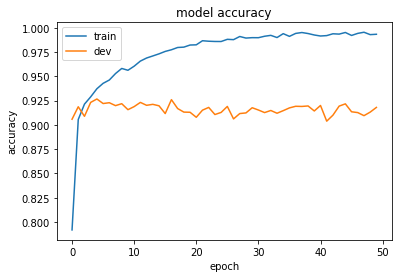

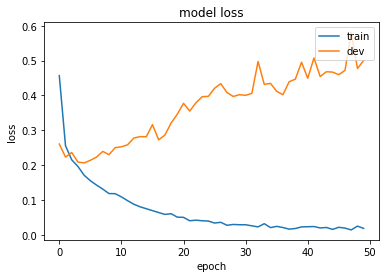

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper right')
plt.show()

In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense, Dropout, Bidirectional, LSTM, Embedding, Input
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
from tensorflow.keras import Model
from sklearn.metrics import f1_score, recall_score, precision_score, classification_report, precision_recall_curve, auc, plot_confusion_matrix, average_precision_score, auc, roc_auc_score

DENSE = 64

with tf.device('/device:GPU:0'):

  # create empty sequential model
  model2 = Sequential()
  # add an embedding layer
  model2.add(Embedding(input_dim=MAX_WORDS, # Size of the vocabulary, i.e. maximum integer index + 1
                      output_dim=EMBEDDING_DIM, 
                      weights=[embedding_matrix], 
                      input_length=MAX_SEQUENCE_LENGTH, trainable=False))
  # add 0.2 dropout probabillity
  model2.add(Dropout(0.2))
  # add a stack of convolution layers
  model2.add(Conv1D(filters=FILTERS, kernel_size=KERNEL, activation='relu', padding='valid'))
  model2.add(Conv1D(filters=FILTERS, kernel_size=KERNEL, activation='relu', padding='valid'))
  model2.add(Conv1D(filters=FILTERS, kernel_size=KERNEL, activation='relu', padding='valid'))
  model2.add(Conv1D(filters=FILTERS, kernel_size=KERNEL, activation='relu', padding='valid'))
  model2.add(Conv1D(filters=FILTERS, kernel_size=KERNEL, activation='relu', padding='valid'))
  # max pooling
  model2.add(GlobalMaxPooling1D())
  # add 0.2 dropout probabillity
  model2.add(Dropout(0.2))
  # add dense layer
  model2.add(Dense(DENSE, activation='relu'))
  # add final linear layer
  model2.add(Dense(N_CLASSES, activation='sigmoid'))

  print(model2.summary())
  
  # Load weights from the pre-trained model
  model2.load_weights("/content/gdrive/My Drive/checkpoints/stackedCNN.hdf5")
  
  print("Dev set performance")
  predictions_val = np.argmax(model2.predict(dev_data), -1)
  print(classification_report(dev_y_, predictions_val, target_names=target_list))

  print()
  print("Training set performance") # Overfitting on training set
  predictions_train = np.argmax(model2.predict(train_data), -1)
  print(classification_report(train_y_, predictions_train, target_names=target_list))

# calculating more metrics
  pred = model2.predict(dev_data)
  # For each class
  precision_ = dict()
  recall_ = dict()
  average_precision = dict()
  area = dict()
  for i in range(4):
      precision_[i], recall_[i], _ = precision_recall_curve(dev_y[:, i], pred[:, i])
      average_precision[i] = average_precision_score(dev_y[:, i], pred[:, i])
      # A "micro-average": quantifying score on each class
      category = "micro-" + target_list[i]
      precision_[category], recall_[category], _ = precision_recall_curve(
      dev_y[:, i], pred[:, i])
      area[category] = auc(recall_[category], precision_[category])

  # A "micro-average": quantifying score on all classes jointly
  precision_["micro"], recall_["micro"], _ = precision_recall_curve(
      dev_y.ravel(), pred.ravel()
  )
  area_all = auc(recall_['micro'], precision_['micro'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 200, 300)          3000000   
                                                                 
 dropout_2 (Dropout)         (None, 200, 300)          0         
                                                                 
 conv1d_5 (Conv1D)           (None, 198, 128)          115328    
                                                                 
 conv1d_6 (Conv1D)           (None, 196, 128)          49280     
                                                                 
 conv1d_7 (Conv1D)           (None, 194, 128)          49280     
                                                                 
 conv1d_8 (Conv1D)           (None, 192, 128)          49280     
                                                                 
 conv1d_9 (Conv1D)           (None, 190, 128)         

# ***Fine Tuning the stacked CNNs using Keras Tuner***

In [ ]:
def model_builder_stacked(hp):
  model = tf.keras.Sequential()

  MAX_WORDS = 10000
  MAX_SEQUENCE_LENGTH = 200
  EMBEDDING_DIM = 300

  FILTERS = 128  # the dimensionality of the output space (i.e. the number of output filters in the convolution)
  # KERNEL = 3  # the length of the 1D convolution window
  DENSE = hp.Int('hidden_layer_units', min_value = 64, max_value = 512, step = 64)
  N_CLASSES = 4

  target_list = ["World", "Sports", "Business", "Sci/Tech"]

  hp_dropout_embs = hp.Float('dropout_rate_emb', min_value=0.1, max_value=0.5,step=0.1)
  hp_dropout = hp.Float('dropout_rate', min_value=0.1, max_value=0.5,step=0.1)
  
  hp_activation = hp.Choice("activation", ["relu", "tanh", "sigmoid"])

   # create empty sequential model
  model3 = Sequential()
  # add an embedding layer
  model3.add(Embedding(input_dim=MAX_WORDS, # Size of the vocabulary, i.e. maximum integer index + 1
                      output_dim=EMBEDDING_DIM, 
                      weights=[embedding_matrix], 
                      input_length=MAX_SEQUENCE_LENGTH, trainable=False))

  # Dropout over Embeddings
  model3.add(Dropout(hp_dropout_embs))

  # I need to fine tune the hyperparameters eg number of layers, kernel size...

  for i in range(hp.Int('num_layers', 1, 5)):

    hp_kernels = hp.Choice("hp_kernel_size", [2, 3, 4, 5])
    # hp_activation = hp.Choice("activation", ["relu", "tanh", "sigmoid"])

    model3.add(Conv1D(filters = FILTERS, kernel_size = hp_kernels, activation = hp_activation, padding='valid'))

  # max pooling
  model3.add(GlobalMaxPooling1D())

  # add 0.2 dropout probabillity
  model3.add(Dropout(hp_dropout))

  # add dense layer
  model3.add(Dense(DENSE, activation='relu'))

  # add final linear layer
  model3.add(Dense(N_CLASSES, activation='sigmoid'))

  print(model3.summary())
  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  #hp_learning_rate = hp.Choice('learning_rate', values=[5e-3, 1e-3, 5e-4, 1e-4])
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-3, 5e-4, 1e-4, 5e-5, 1e-5])
  #hp_optimizer = hp.Choice('optimizer', ['Adam', 'sgd'])
  model3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss='categorical_crossentropy',
                metrics=[precision, recall, f1, accuracy])

  return model3

In [ ]:
!pip3 install -q -U keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.7/135.7 KB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 40.9 MB/s eta 0:00:00


In [ ]:
import keras_tuner as kt

with tf.device('/device:GPU:0'):
  stacked_tuner_= kt.RandomSearch(model_builder_stacked,
                      objective=kt.Objective("val_accuracy", direction="max"),
                      max_trials=20,
                      directory="nlp5-1",
                      project_name="CNNfinetuning1")

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 200, 300)          3000000   
                                                                 
 dropout_4 (Dropout)         (None, 200, 300)          0         
                                                                 
 conv1d_10 (Conv1D)          (None, 199, 128)          76928     
                                                                 
 global_max_pooling1d_2 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                      

In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)

In [ ]:
stacked_tuner_.search(train_data, train_y, epochs=20, batch_size=64, callbacks=[stop_early], validation_data=(dev_data, dev_y))

Trial 20 Complete [00h 00m 17s]
val_accuracy: 0.7901666760444641

Best val_accuracy So Far: 0.8601666688919067
Total elapsed time: 00h 05m 26s


In [ ]:
# Get the optimal hyperparameters
best_hps_stacked=stacked_tuner_.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The optimal number of stacked layers is {best_hps_stacked.get('num_layers')}. The best activation function is {best_hps_stacked.get('learning_rate')} The optimal number of neurons in the dense layer is {best_hps_stacked.get('hidden_layer_units')}.
""")


The optimal number of stacked layers is 1. The best activation function is 0.001 The optimal number of neurons in the dense layer is 192.



In [ ]:
stacked_fine_model = stacked_tuner_.hypermodel.build(best_hps_stacked)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 200, 300)          3000000   
                                                                 
 dropout_2 (Dropout)         (None, 200, 300)          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 198, 128)          115328    
                                                                 
 global_max_pooling1d_1 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 192)               24768     
                                                      

In [ ]:
print(stacked_fine_model.summary())

history = stacked_fine_model.fit(
    train_data, 
    train_y,
    validation_data=(dev_data, dev_y),
    batch_size=256,
    epochs=30,
    shuffle=True,
    callbacks=[checkpoint]
    )

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 200, 300)          3000000   
                                                                 
 dropout_2 (Dropout)         (None, 200, 300)          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 198, 128)          115328    
                                                                 
 global_max_pooling1d_1 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 192)               24768     
                                                      

In [ ]:
predictions_val = stacked_fine_model.predict(dev_data)

# report_lr_dev = classification_report(dev_y_, predictions_val, target_names=target_list, output_dict=True)
#print(classification_report(dev_y_, predictions_val, target_names=target_list))

47/47 [==============================] - 0s 4ms/step


## Multi-filter CNNs for text classification

In [ ]:
# Set global environment variable
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [ ]:
# Global statements for CNN classifier
FILTERS = 128
DENSE = 256
KERNEL = 3
N_CLASSES = 4 

In [ ]:
# Inputs
inputs = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype="int32")

# Embeddings
embeddings = Embedding(input_dim=MAX_WORDS, 
                        output_dim=EMBEDDING_DIM, weights=[embedding_matrix],
                        input_length=MAX_SEQUENCE_LENGTH, trainable=False)(inputs)

# Dropout over Embeddings
dropped_embeddings = Dropout(rate=0.2)(embeddings)

# Multi-filter CNNs
pooled_convs = []
filter_sizes = [2,3,4]
for n_gram in filter_sizes:
    convs = Conv1D(filters=FILTERS, kernel_size=n_gram, strides=1, 
                    padding="same", activation='relu', 
                    name='{}-gram_Convolutions'.format(n_gram))(dropped_embeddings)
    pooled_convs.append(GlobalMaxPooling1D(name='{}-gram_MaxPool'.format(n_gram))(convs))

# Concatenation of filters form all window sizes
concat =  concatenate(pooled_convs)
concat = Dropout(rate=0.5)(concat)
outputs = Dense(N_CLASSES, activation='sigmoid')(concat)

# Create the model
model = Model(inputs=inputs, outputs=outputs)

In [ ]:
# Print model's summary
print(model.summary()) 

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 200)]        0           []                               
                                                                                                  
 embedding_6 (Embedding)        (None, 200, 300)     3000000     ['input_7[0][0]']                
                                                                                                  
 dropout_6 (Dropout)            (None, 200, 300)     0           ['embedding_6[0][0]']            
                                                                                                  
 2-gram_Convolutions (Conv1D)   (None, 200, 128)     76928       ['dropout_6[0][0]']              
                                                                                            

In [ ]:
# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.001),
              metrics=[precision, recall, f1, accuracy])

checkpoint = ModelCheckpoint('/content/gdrive/My Drive/keras_Deep_CNN_model', monitor='val_f1', verbose=1, save_best_only=True, mode='max')

checkpoint2 = ModelCheckpoint('/content/gdrive/My Drive/checkpoints/multifilterCNN.hdf5',
                               monitor='val_accuracy', 
                               mode='max', verbose=2,
                               save_best_only=True,
                               save_weights_only=True)

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
# And fit
history = model.fit(train_data,
                      train_y,
                      batch_size=32,
                      epochs=50,
                      verbose = 0,
                      callbacks=[checkpoint, checkpoint2],
                      validation_data=(dev_data, dev_y),
                      shuffle=True) 


Epoch 1: val_f1 improved from -inf to 0.65713, saving model to /content/gdrive/My Drive/keras_Deep_CNN_model



Epoch 1: val_accuracy improved from -inf to 0.75283, saving model to /content/gdrive/My Drive/checkpoints/multifilterCNN.hdf5

Epoch 2: val_f1 improved from 0.65713 to 0.68874, saving model to /content/gdrive/My Drive/keras_Deep_CNN_model



Epoch 2: val_accuracy improved from 0.75283 to 0.78317, saving model to /content/gdrive/My Drive/checkpoints/multifilterCNN.hdf5

Epoch 3: val_f1 improved from 0.68874 to 0.72336, saving model to /content/gdrive/My Drive/keras_Deep_CNN_model



Epoch 3: val_accuracy improved from 0.78317 to 0.81667, saving model to /content/gdrive/My Drive/checkpoints/multifilterCNN.hdf5

Epoch 4: val_f1 did not improve from 0.72336

Epoch 4: val_accuracy did not improve from 0.81667

Epoch 5: val_f1 did not improve from 0.72336

Epoch 5: val_accuracy did not improve from 0.81667

Epoch 6: val_f1 improved from 0.72336 to 0.73457, saving model to /content/gdrive/My Drive/keras_Deep_CNN_model



Epoch 6: val_accuracy improved from 0.81667 to 0.82533, saving model to /content/gdrive/My Drive/checkpoints/multifilterCNN.hdf5

Epoch 7: val_f1 did not improve from 0.73457

Epoch 7: val_accuracy did not improve from 0.82533

Epoch 8: val_f1 did not improve from 0.73457

Epoch 8: val_accuracy did not improve from 0.82533

Epoch 9: val_f1 did not improve from 0.73457

Epoch 9: val_accuracy did not improve from 0.82533

Epoch 10: val_f1 improved from 0.73457 to 0.74108, saving model to /content/gdrive/My Drive/keras_Deep_CNN_model



Epoch 10: val_accuracy improved from 0.82533 to 0.83067, saving model to /content/gdrive/My Drive/checkpoints/multifilterCNN.hdf5

Epoch 11: val_f1 did not improve from 0.74108

Epoch 11: val_accuracy improved from 0.83067 to 0.83133, saving model to /content/gdrive/My Drive/checkpoints/multifilterCNN.hdf5

Epoch 12: val_f1 did not improve from 0.74108

Epoch 12: val_accuracy did not improve from 0.83133

Epoch 13: val_f1 improved from 0.74108 to 0.74775, saving model to /content/gdrive/My Drive/keras_Deep_CNN_model



Epoch 13: val_accuracy improved from 0.83133 to 0.83800, saving model to /content/gdrive/My Drive/checkpoints/multifilterCNN.hdf5

Epoch 14: val_f1 improved from 0.74775 to 0.75852, saving model to /content/gdrive/My Drive/keras_Deep_CNN_model



Epoch 14: val_accuracy improved from 0.83800 to 0.84650, saving model to /content/gdrive/My Drive/checkpoints/multifilterCNN.hdf5

Epoch 15: val_f1 did not improve from 0.75852

Epoch 15: val_accuracy did not improve from 0.84650

Epoch 16: val_f1 improved from 0.75852 to 0.77006, saving model to /content/gdrive/My Drive/keras_Deep_CNN_model



Epoch 16: val_accuracy improved from 0.84650 to 0.85633, saving model to /content/gdrive/My Drive/checkpoints/multifilterCNN.hdf5

Epoch 17: val_f1 did not improve from 0.77006

Epoch 17: val_accuracy did not improve from 0.85633

Epoch 18: val_f1 did not improve from 0.77006

Epoch 18: val_accuracy did not improve from 0.85633

Epoch 19: val_f1 did not improve from 0.77006

Epoch 19: val_accuracy did not improve from 0.85633

Epoch 20: val_f1 improved from 0.77006 to 0.77956, saving model to /content/gdrive/My Drive/keras_Deep_CNN_model



Epoch 20: val_accuracy improved from 0.85633 to 0.86467, saving model to /content/gdrive/My Drive/checkpoints/multifilterCNN.hdf5

Epoch 21: val_f1 did not improve from 0.77956

Epoch 21: val_accuracy improved from 0.86467 to 0.86483, saving model to /content/gdrive/My Drive/checkpoints/multifilterCNN.hdf5

Epoch 22: val_f1 did not improve from 0.77956

Epoch 22: val_accuracy did not improve from 0.86483

Epoch 23: val_f1 did not improve from 0.77956

Epoch 23: val_accuracy did not improve from 0.86483

Epoch 24: val_f1 improved from 0.77956 to 0.78921, saving model to /content/gdrive/My Drive/keras_Deep_CNN_model



Epoch 24: val_accuracy improved from 0.86483 to 0.87267, saving model to /content/gdrive/My Drive/checkpoints/multifilterCNN.hdf5

Epoch 25: val_f1 improved from 0.78921 to 0.79044, saving model to /content/gdrive/My Drive/keras_Deep_CNN_model



Epoch 25: val_accuracy improved from 0.87267 to 0.87450, saving model to /content/gdrive/My Drive/checkpoints/multifilterCNN.hdf5

Epoch 26: val_f1 did not improve from 0.79044

Epoch 26: val_accuracy did not improve from 0.87450

Epoch 27: val_f1 did not improve from 0.79044

Epoch 27: val_accuracy did not improve from 0.87450

Epoch 28: val_f1 did not improve from 0.79044

Epoch 28: val_accuracy did not improve from 0.87450

Epoch 29: val_f1 did not improve from 0.79044

Epoch 29: val_accuracy did not improve from 0.87450

Epoch 30: val_f1 did not improve from 0.79044

Epoch 30: val_accuracy did not improve from 0.87450

Epoch 31: val_f1 did not improve from 0.79044

Epoch 31: val_accuracy did not improve from 0.87450

Epoch 32: val_f1 did not improve from 0.79044

Epoch 32: val_accuracy did not improve from 0.87450

Epoch 33: val_f1 improved from 0.79044 to 0.79630, saving model to /content/gdrive/My Drive/keras_Deep_CNN_model



Epoch 33: val_accuracy improved from 0.87450 to 0.87900, saving model to /content/gdrive/My Drive/checkpoints/multifilterCNN.hdf5

Epoch 34: val_f1 did not improve from 0.79630

Epoch 34: val_accuracy did not improve from 0.87900

Epoch 35: val_f1 did not improve from 0.79630

Epoch 35: val_accuracy did not improve from 0.87900

Epoch 36: val_f1 did not improve from 0.79630

Epoch 36: val_accuracy did not improve from 0.87900

Epoch 37: val_f1 did not improve from 0.79630

Epoch 37: val_accuracy did not improve from 0.87900

Epoch 38: val_f1 improved from 0.79630 to 0.79999, saving model to /content/gdrive/My Drive/keras_Deep_CNN_model



Epoch 38: val_accuracy improved from 0.87900 to 0.88200, saving model to /content/gdrive/My Drive/checkpoints/multifilterCNN.hdf5

Epoch 39: val_f1 did not improve from 0.79999

Epoch 39: val_accuracy did not improve from 0.88200

Epoch 40: val_f1 did not improve from 0.79999

Epoch 40: val_accuracy did not improve from 0.88200

Epoch 41: val_f1 did not improve from 0.79999

Epoch 41: val_accuracy did not improve from 0.88200

Epoch 42: val_f1 did not improve from 0.79999

Epoch 42: val_accuracy did not improve from 0.88200

Epoch 43: val_f1 did not improve from 0.79999

Epoch 43: val_accuracy did not improve from 0.88200

Epoch 44: val_f1 did not improve from 0.79999

Epoch 44: val_accuracy did not improve from 0.88200

Epoch 45: val_f1 did not improve from 0.79999

Epoch 45: val_accuracy did not improve from 0.88200

Epoch 46: val_f1 did not improve from 0.79999

Epoch 46: val_accuracy did not improve from 0.88200

Epoch 47: val_f1 did not improve from 0.79999

Epoch 47: val_accurac


Epoch 48: val_accuracy improved from 0.88200 to 0.88583, saving model to /content/gdrive/My Drive/checkpoints/multifilterCNN.hdf5

Epoch 49: val_f1 did not improve from 0.80576

Epoch 49: val_accuracy did not improve from 0.88583

Epoch 50: val_f1 did not improve from 0.80576

Epoch 50: val_accuracy did not improve from 0.88583


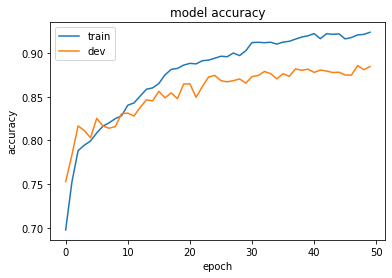

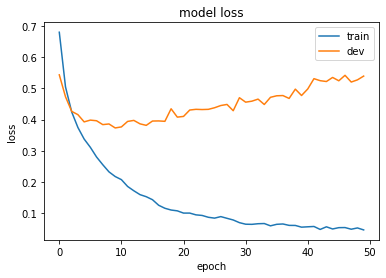

In [ ]:
# Summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()

# Summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper right')
plt.show()

In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense, Dropout, Bidirectional, LSTM, Embedding, Input
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
from tensorflow.keras import Model
from sklearn.metrics import f1_score, recall_score, precision_score, classification_report, precision_recall_curve, auc, plot_confusion_matrix, average_precision_score, auc, roc_auc_score

DENSE = 64

with tf.device('/device:GPU:0'):

  # Inputs
  inputs = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype="int32")

  # Embeddings
  embeddings = Embedding(input_dim=MAX_WORDS, 
                          output_dim=EMBEDDING_DIM, weights=[embedding_matrix],
                          input_length=MAX_SEQUENCE_LENGTH, trainable=False)(inputs)

  # Dropout over Embeddings
  #dropped_embeddings = Dropout(rate=0.2)(embeddings)

  # Multi-filter CNNs
  pooled_convs = []
  filter_sizes = [2,3,4]
  for n_gram in filter_sizes:
      convs = Conv1D(filters=FILTERS, kernel_size=n_gram, strides=1, 
                      padding="same", activation='relu', 
                      name='{}-gram_Convolutions'.format(n_gram))(embeddings)
      pooled_convs.append(GlobalMaxPooling1D(name='{}-gram_MaxPool'.format(n_gram))(convs))

  # Concatenation of filters form all window sizes
  concat =  concatenate(pooled_convs)
  #concat = Dropout(rate=0.5)(concat)
  outputs = Dense(N_CLASSES, activation='sigmoid')(concat)

  # Create the model
  model_ = Model(inputs=inputs, outputs=outputs)

  # Load weights from the pre-trained model
  model_.load_weights("/content/gdrive/My Drive/checkpoints/multifilterCNN.hdf5")

  print("Dev set performance")
  predictions_val = np.argmax(model_.predict(dev_data), -1)
  print(classification_report(dev_y_, predictions_val, target_names=target_list))

  print()
  print("Training set performance") # Overfitting on training set
  predictions_train = np.argmax(model_.predict(train_data), -1)
  print(classification_report(train_y_, predictions_train, target_names=target_list))

  # calculating more metrics
  pred = model_.predict(dev_data)
  # For each class
  precision_ = dict()
  recall_ = dict()
  average_precision = dict()
  area = dict()
  for i in range(4):
      precision_[i], recall_[i], _ = precision_recall_curve(dev_y[:, i], pred[:, i])
      average_precision[i] = average_precision_score(dev_y[:, i], pred[:, i])
      # A "micro-average": quantifying score on each class
      category = "micro-" + target_list[i]
      precision_[category], recall_[category], _ = precision_recall_curve(
      dev_y[:, i], pred[:, i])
      area[category] = auc(recall_[category], precision_[category])

  # A "micro-average": quantifying score on all classes jointly
  precision_["micro"], recall_["micro"], _ = precision_recall_curve(
      dev_y.ravel(), pred.ravel()
  )
  area_all = auc(recall_['micro'], precision_['micro'])

Dev set performance
47/47 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

       World       0.87      0.89      0.88       435
      Sports       0.93      0.96      0.95       535
    Business       0.82      0.77      0.79       331
    Sci/Tech       0.76      0.76      0.76       199

    accuracy                           0.87      1500
   macro avg       0.85      0.84      0.84      1500
weighted avg       0.87      0.87      0.87      1500


Training set performance
188/188 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

       World       1.00      1.00      1.00      1547
      Sports       1.00      1.00      1.00      1302
    Business       1.00      1.00      1.00      1449
    Sci/Tech       1.00      1.00      1.00      1702

    accuracy                           1.00      6000
   macro avg       1.00      1.00      1.00      6000
weighted avg       1.00      1.

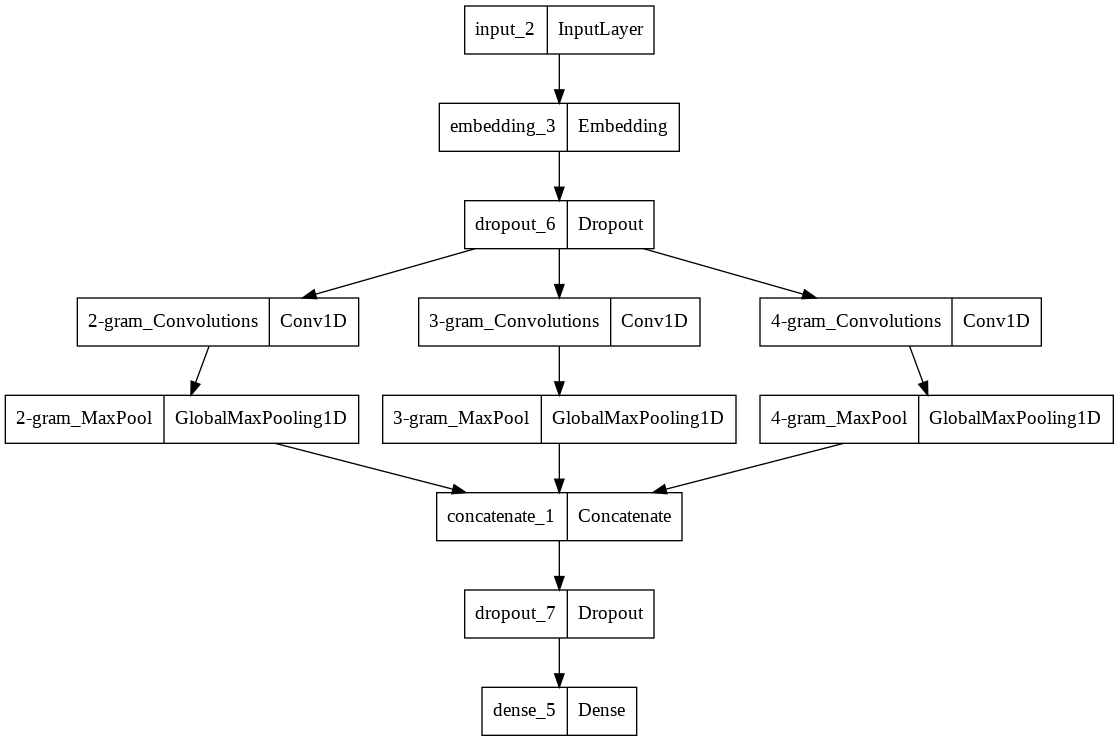

In [ ]:
# Plot our model's architecture
plot_model(model, to_file='model.png')
Image('model.png')

# ***Fine Tuning the multi filter CNN using Keras Tuner***

In [ ]:
def model_builder(hp):
  model = tf.keras.Sequential()

  MAX_WORDS = 10000
  MAX_SEQUENCE_LENGTH = 200
  EMBEDDING_DIM = 300

  target_list = ["World", "Sports", "Business", "Sci/Tech"]

  hp_dropout_embs = hp.Float('dropout_rate_emb', min_value=0.1, max_value=0.5,step=0.1)
  hp_dropout = hp.Float('dropout_rate', min_value=0.1, max_value=0.5,step=0.1)

  inputs = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype="int32")

  # Embeddings
  embeddings = Embedding(input_dim=MAX_WORDS, 
                        output_dim=EMBEDDING_DIM, weights=[embedding_matrix],
                        input_length=MAX_SEQUENCE_LENGTH, trainable=False)(inputs)

  # Dropout over Embeddings
  dropped_embeddings = Dropout(rate=hp_dropout_embs)(embeddings)

  # I need to fine tune the hyperparameters eg

  # Multi-filter CNNs
  pooled_convs = []
  filter_sizes = [2,3,4]
  for n_gram in filter_sizes:
      convs = Conv1D(filters=FILTERS, kernel_size=n_gram, strides=1, 
                      padding="same", activation='relu', 
                      name='{}-gram_Convolutions'.format(n_gram))(dropped_embeddings)
      pooled_convs.append(GlobalMaxPooling1D(name='{}-gram_MaxPool'.format(n_gram))(convs))

  # Concatenation of filters form all window sizes
  concat =  concatenate(pooled_convs)
  concat = Dropout(rate=hp_dropout)(concat)
  outputs = Dense(N_CLASSES, activation='sigmoid')(concat)



  model_ft = Model(inputs, outputs=outputs)
  print(model_ft.summary())
  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  #hp_learning_rate = hp.Choice('learning_rate', values=[5e-3, 1e-3, 5e-4, 1e-4])
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-3, 5e-4, 1e-4, 5e-5, 1e-5])
  #hp_optimizer = hp.Choice('optimizer', ['Adam', 'sgd'])
  model_ft.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss='categorical_crossentropy',
                metrics=[precision, recall, f1, accuracy])

  return model_ft

In [ ]:
!pip3 install -q -U keras-tuner

In [ ]:
import keras_tuner as kt

with tf.device('/device:GPU:0'):
  tuner_= kt.RandomSearch(model_builder,
                      objective=kt.Objective("val_accuracy", direction="max"),
                      max_trials=20,
                      directory="nlp5-2",
                      project_name="CNNfinetuning1")

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 200)]        0           []                               
                                                                                                  
 embedding_4 (Embedding)        (None, 200, 300)     3000000     ['input_3[0][0]']                
                                                                                                  
 dropout_8 (Dropout)            (None, 200, 300)     0           ['embedding_4[0][0]']            
                                                                                                  
 2-gram_Convolutions (Conv1D)   (None, 200, 128)     76928       ['dropout_8[0][0]']              
                                                                                            

In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)

In [ ]:
tuner_.search(train_data, train_y, epochs=15, batch_size=64, callbacks=[stop_early], validation_data=(dev_data, dev_y))

Trial 20 Complete [00h 00m 09s]
val_accuracy: 0.8274999856948853

Best val_accuracy So Far: 0.8914999961853027
Total elapsed time: 00h 09m 18s


In [ ]:
# Get the optimal hyperparameters
best_hps=tuner_.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The optimal embedding dropout rate is {best_hps.get('dropout_rate_emb')}, the optimal dropout rate is {best_hps.get('dropout_rate')} .""")


The optimal embedding dropout rate is 0.1, the optimal dropout rate is 0.1 .


In [ ]:
fine_model = tuner_.hypermodel.build(best_hps)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 200)]        0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 200, 300)     3000000     ['input_2[0][0]']                
                                                                                                  
 dropout_2 (Dropout)            (None, 200, 300)     0           ['embedding_1[0][0]']            
                                                                                                  
 2-gram_Convolutions (Conv1D)   (None, 200, 128)     76928       ['dropout_2[0][0]']              
                                                                                            

In [ ]:
print(fine_model.summary())

history = fine_model.fit(
    train_data, 
    train_y,
    validation_data=(dev_data, dev_y),
    batch_size=256,
    epochs=20,
    shuffle=True,
    callbacks=[checkpoint]
    )

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 200)]        0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 200, 300)     3000000     ['input_2[0][0]']                
                                                                                                  
 dropout_2 (Dropout)            (None, 200, 300)     0           ['embedding_1[0][0]']            
                                                                                                  
 2-gram_Convolutions (Conv1D)   (None, 200, 128)     76928       ['dropout_2[0][0]']              
                                                                                            

In [ ]:
predictions_val = fine_model.predict(dev_data)

#report_lr_dev = classification_report(dev_y, predictions_val, target_names=target_list, output_dict=True)

47/47 [==============================] - 0s 3ms/step
